In [1]:
import glob
import os

from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd 
import scipy.stats as st
from sklearn.neighbors import KernelDensity

import huxt as H
import huxt_analysis as HA
import sir_huxt_v as shv


mpl.rc("axes", labelsize=16)
mpl.rc("ytick", labelsize=16)
mpl.rc("xtick", labelsize=16)
mpl.rc("legend", fontsize=16)


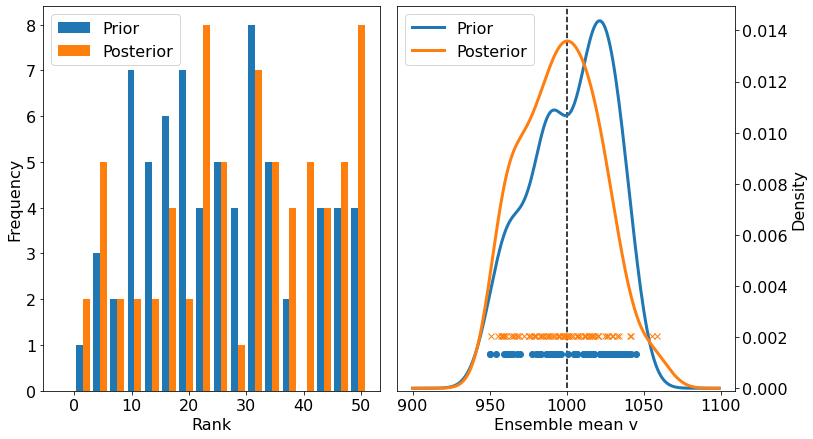

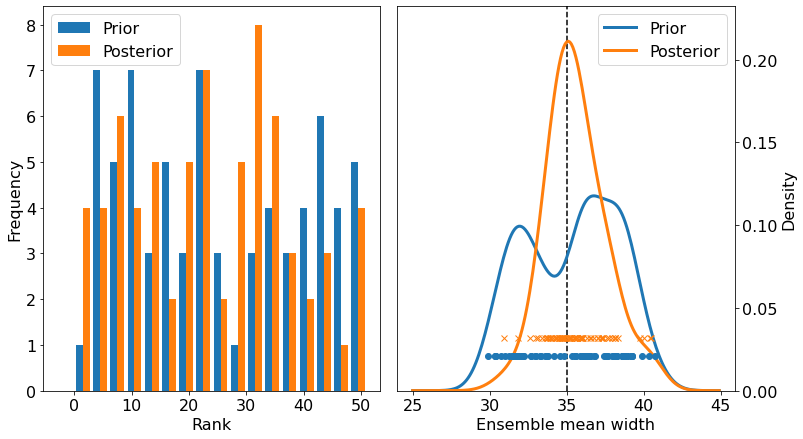

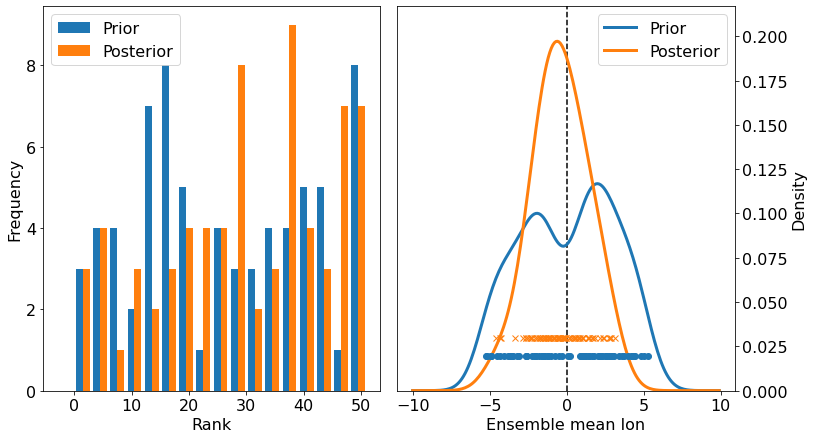

In [2]:
dirs = shv.get_project_dirs()
data_dir = os.path.join(dirs['sir_analysis'], "shvwl_calibrate_v2", "SIR_HUXt_*.hdf5")
files = glob.glob(data_dir)
files = files[:-1]

# Get ranks and ensemble means of the priors
v_rank_prior = [] 
v_avg_prior = []

ess_prior = []

params = ['v_truth', 'v_avg', 'v_rank', 'v_std',
          'width_truth', 'width_avg', 'width_rank', 'width_std',
          'lon_truth', 'lon_avg', 'lon_rank', 'lon_std',
          'ess']

data = {key: {param_key:[] for param_key in params} for key in ['prior', 'post']}

for key in ['prior', 'post']:

    if key == 'prior':
        analysis_key = 'analysis_00'
    elif key == 'post':
        analysis_key = 'analysis_07'
        
    for f in files: 

        out_file = h5py.File(f, 'r')
        
        cme_truth_params = out_file['truth_cme_params'][:]
        data[key]['lon_truth'] = np.rad2deg(cme_truth_params[1])
        data[key]['width_truth'] = np.rad2deg(cme_truth_params[3])
        data[key]['v_truth'] = cme_truth_params[4]
        
        if data[key]['lon_truth'] > 180:
            data[key]['lon_truth'] -= 360
        
        for param in ['v', 'lon', 'width']:
        
            # Rank the truth amongst prior ensemble
            # Speed first
            vals = out_file[analysis_key][param][:]
            n_ens = len(vals)
            if param == 'lon':
                vals[vals>180] -= 360
                
            val_truth = data[key][param + '_truth']
            vals_all = np.append(vals, val_truth)
            vals_ranks = st.rankdata(vals_all)
            data[key][param + '_rank'].append(vals_ranks[-1])
            # Ensemble mean of prior
            data[key][param + '_avg'].append(np.mean(vals))
            data[key][param + '_std'].append(np.std(vals))
        
        out_file.close()
        
# Produce rank-histograms and dist of ensemble mean
bins = np.arange(-3, n_ens+3, 3)
bw = {'v':10, 'lon':1, 'width':1}
grid =  {'v':np.arange(900, 1100, 1), 'lon':np.arange(-10, 10, 0.1), 'width':np.arange(25, 45, 0.1)}
for param in ['v', 'width', 'lon']:
    
    ranks = [data['prior'][param + '_rank'], data['post'][param + '_rank']]
    val_pri = data['prior'][param + '_avg']
    val_pos = data['post'][param + '_avg']
    val_truth = data['prior'][param + '_truth']         
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    
    ax[0].hist(ranks, bins=bins, label=['Prior', 'Posterior'])
    
    cmap = plt.get_cmap("tab10")
    
    for val, col, label in zip([val_pri, val_pos], [cmap(0), cmap(1)], ['Prior', 'Posterior']):
        
        kde = KernelDensity(kernel='gaussian', bandwidth=bw[param]).fit(np.array(val).reshape(-1, 1))
        log_pdf = kde.score_samples(grid[param].reshape(-1,1))
        pdf = np.exp(log_pdf)
        ax[1].plot(grid[param], pdf, color=col, label=label, linewidth=3)
    
    y = np.zeros(len(val_pri)) + 0.1*np.max(pdf)    
    ax[1].plot(val_pri, y, 'o', color=cmap(0))

    y = np.zeros(len(val_pos)) + 0.15*np.max(pdf)    
    ax[1].plot(val_pos, y, 'x', color=cmap(1))

    ax[1].vlines(val_truth, 0, 2*np.max(pdf), linestyles=['--'], colors=['k'])

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position("right")

    ax[0].set_xlabel('Rank')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    ax[1].set_xlabel('Ensemble mean ' + param)
    ax[1].set_ylabel('Density')
    ax[1].set_ylim(-0.0001, 1.1*np.max(pdf))
    #ax[1].set_xlim(900, 1100)
    ax[1].legend()

    fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.99, wspace=0.05)

 

Speed: 040/071
Width: 056/071
Lon: 053/071


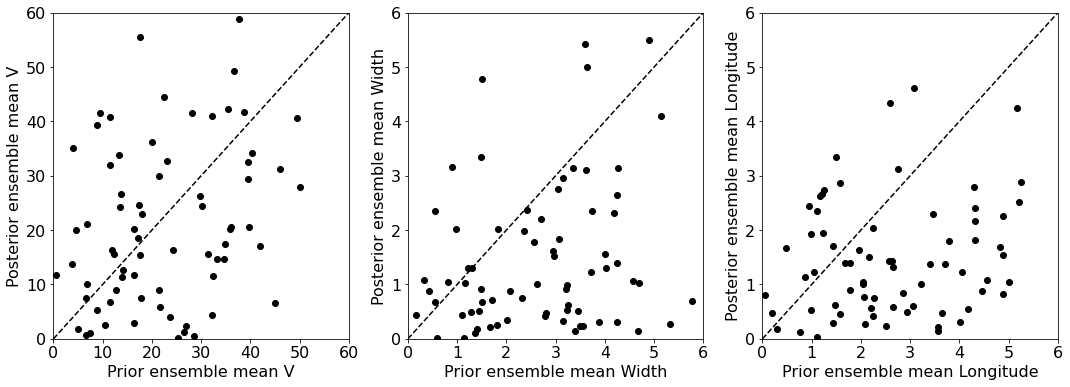

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
dv_pri = np.abs(np.array(data['prior']['v_avg']) - 1000)
dv_pos = np.abs(np.array(data['post']['v_avg']) - 1000)

count = np.sum(dv_pos < dv_pri)
tot  = dv_pos.size
print("Speed: {:03d}/{:03d}".format(count, tot))

ax[0].plot(dv_pri, dv_pos, 'ko')
ax[0].plot([0, 100], [0, 100],'k--')
ax[0].set_xlim(0, 60)
ax[0].set_ylim(0, 60)

dw_pri = np.abs(np.array(data['prior']['width_avg']) - 35)
dw_pos = np.abs(np.array(data['post']['width_avg']) - 35)

count = np.sum(dw_pos < dw_pri)
tot = dw_pos.size
print("Width: {:03d}/{:03d}".format(count, tot))

ax[1].plot(dw_pri, dw_pos, 'ko')
ax[1].plot([0, 100], [0, 100],'k--')
ax[1].set_xlim(0, 6)
ax[1].set_ylim(0, 6)

dl_pri = np.abs(np.array(data['prior']['lon_avg']) - 0)
dl_pos = np.abs(np.array(data['post']['lon_avg']) - 0)

count = np.sum(dl_pos < dl_pri)
tot = dl_pos.size
print("Lon: {:03d}/{:03d}".format(count, tot))


ax[2].plot(dl_pri, dl_pos, 'ko')
ax[2].plot([0, 100], [0, 100],'k--')
ax[2].set_xlim(0, 6)
ax[2].set_ylim(0, 6)

for a, lab in zip(ax, ['V', 'Width', 'Longitude']):

    a.set_xlabel('Prior ensemble mean {}'.format(lab))
    a.set_ylabel('Posterior ensemble mean {}'.format(lab))


Speed: 054/071
Width: 069/071
Lon: 065/071


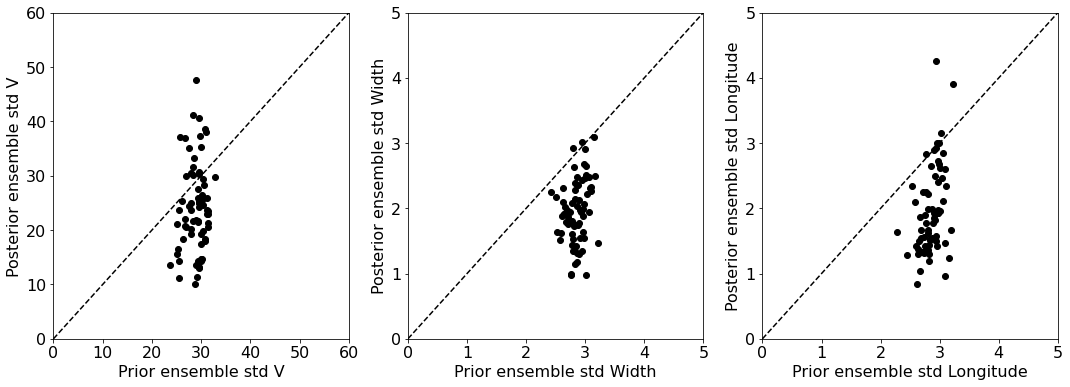

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
dv_pri = np.array(data['prior']['v_std'])
dv_pos = np.array(data['post']['v_std'])

count = np.sum(dv_pos < dv_pri)
tot  = dv_pos.size
print("Speed: {:03d}/{:03d}".format(count, tot))

ax[0].plot(dv_pri, dv_pos, 'ko')
ax[0].plot([0, 100], [0, 100],'k--')
ax[0].set_xlim(0, 60)
ax[0].set_ylim(0, 60)

dw_pri = np.array(data['prior']['width_std'])
dw_pos = np.array(data['post']['width_std'])

count = np.sum(dw_pos < dw_pri)
tot = dw_pos.size
print("Width: {:03d}/{:03d}".format(count, tot))

ax[1].plot(dw_pri, dw_pos, 'ko')
ax[1].plot([0, 100], [0, 100],'k--')
ax[1].set_xlim(0, 5)
ax[1].set_ylim(0, 5)

dl_pri = np.array(data['prior']['lon_std'])
dl_pos = np.array(data['post']['lon_std'])

count = np.sum(dl_pos < dl_pri)
tot = dl_pos.size
print("Lon: {:03d}/{:03d}".format(count, tot))


ax[2].plot(dl_pri, dl_pos, 'ko')
ax[2].plot([0, 100], [0, 100],'k--')
ax[2].set_xlim(0, 5)
ax[2].set_ylim(0, 5)

for a, lab in zip(ax, ['V', 'Width', 'Longitude']):

    a.set_xlabel('Prior ensemble std {}'.format(lab))
    a.set_ylabel('Posterior ensemble std {}'.format(lab))
